In [1]:
import os
import sys
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
pd.options.display.max_columns = None
pd.options.display.max_rows = None
from modules import *
from execution import *
import json

In [2]:
gpt2 = {'l': 1024, 'e': 1600, 'h': 32, 'depth': 48}
gpt3 = {'l': 2048, 'e': 12288, 'h': 96, 'depth': 96}
gpt3_1T = {'l': 2048, 'e': 25600, 'h': 160, 'depth': 180}
gpt3_1T_alt = {'l': 2048, 'e': 32768, 'h': 128, 'depth': 128}
gpt3_lowdepth = {'l': 2048, 'e': 12288, 'h': 256, 'depth': 96 // 8}
vit_era5 = {'l': 64800, 'e': 2048, 'h': 32, 'depth': 32}
vit_era5_big = {'l': 64800, 'e': 12288, 'h': 64, 'depth': 64}
### model
model = gpt3_1T_alt
model_str = 'vit_era5_big'
l = model['l']
e = model['e']
f = 4 * e
model['f'] = f
h = model['h']
depth = model['depth']
print(model)

{'l': 2048, 'e': 32768, 'h': 128, 'depth': 128, 'f': 131072}


In [3]:
with open('config.json', 'r') as file:
    system = json.load(file)

In [ ]:
def print_df(df_mlp, df_sa):
    cols = df_mlp.columns.tolist()
    layer_track_cols = ['activation_buffer', 'weights_mem', 
                        'weights_grad_mem', 'flops_fwd', 'flops_bwd', 
                        't_fwd', 't_fwd_comm', 't_bwd', 't_bwd_comm']
    display(df_mlp[cols])
    display(df_mlp[layer_track_cols].sum())
    display(df_sa[cols])
    display(df_sa[layer_track_cols].sum()) 

In [ ]:
n_gpus = [2048]
global_batch_size = 4096

with open('config.json', 'r') as file:
    system = json.load(file)
system['nvlink_size'] = 4

configs = execute_1d(model, n_gpus, global_batch_size=global_batch_size, 
                     system=system, verbose=False, nlargest=1)
print(configs)

In [4]:
global_batch_size = 4096
with open('config.json', 'r') as file:
    system = json.load(file)

nvs_list = [2, 4, 16, 32]
verbose = False
plots = []

for nvs in nvs_list:
    t = []
    conf = []
    start = None
    system['nvlink_size'] = nvs
    n_gpus = 2**np.array([i for i in range(2,14)])
    configs = execute_1d(model, n_gpus, global_batch_size=global_batch_size, system=system, verbose=False, nlargest=10)
    for s,config in enumerate(configs):
        if len(config) > 0: # check feasibility
            if not start:
                start = s
            conf.append(config)
            t.append([c[0] for c in config])
    # print(t)

    t_max = [tm[0] for tm in t]
    t_min = [tm[-1] for tm in t]
    n_gpus = n_gpus[start:]
    configs = configs[start:]
    
    plots.append((nvs, t_max, t_min, n_gpus, configs))
# np.save('outputs/exec_1d_{}.npy'.format(model_str), np.array(plots, dtype=object))

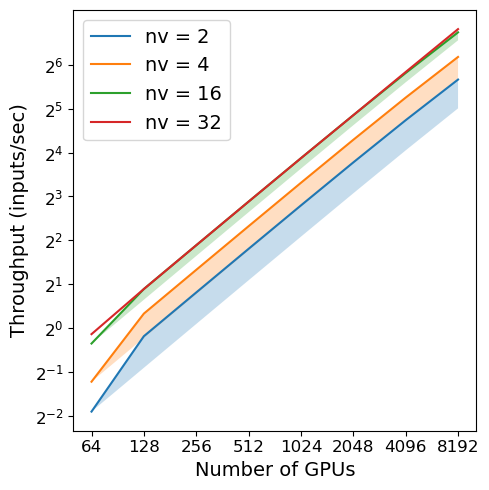

In [5]:
x = np.load('outputs/exec_1d_{}.npy'.format(model_str), allow_pickle=True)
fig, axs = plt.subplots(1,1,figsize=(5,5), tight_layout=True) 

axs.tick_params(axis='both', which='major', labelsize=12)
axs.tick_params(axis='both', which='minor', labelsize=12)
for nvs, t_max, t_min, n_gpus, configs in x:
    axs.plot(n_gpus, t_max, label='nv = {}'.format(nvs))
    axs.fill_between(n_gpus, t_max, t_min, alpha=0.25)
    # print(np.array(t_max) - np.array(t_min))
    axs.set_yscale('log', base=2)
    axs.set_xscale('log', base=2)
    axs.set_xticks(n_gpus)
    axs.set_xticklabels(n_gpus)
    axs.set_xlabel('Number of GPUs', fontsize=14)
    axs.set_ylabel('Throughput (inputs/sec)', fontsize=14)
    axs.set_yticks(2.**np.arange(-2,7))
axs.legend(fontsize=14)
fig.tight_layout()
# plt.savefig('outputs/exec_1d_{}.png'.format(model_str), dpi=400)

In [6]:
def plot_clustered_stacked(dfall, labels=None, title="multiple stacked bar plot",  H="/", **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    # axe = plt.subplot(111)
    fig, axe = plt.subplots(1,1,figsize=(8,8)) 

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      linewidth=0,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      fontsize=15,
                      **kwargs)  # make bar plots
        for c in axe.containers:
            # Optional: if the segment is small or 0, customize the labels
            labels_interior = [str(int(v.get_height())) if v.get_height() > 0 else '' for v in c]
            # remove the labels parameter if it's not needed for customized labels
            axe.bar_label(c, labels=labels_interior, label_type='center', 
                          weight='bold', style='italic', family='serif', rotation=90)

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_hatch(H * int(i / n_col)) #edited part     
                rect.set_width(1 / float(n_df + 1))

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)
    axe.set_title(title)

    # Add invisible data to add another legend
    n=[]        
    for i in range(n_df):
        n.append(axe.bar(0, 0, color="gray", hatch=H * i))

    l1 = axe.legend(h[:n_col], l[:n_col])
    if labels is not None:
        l2 = plt.legend(n, labels, loc=[0.2, 0.85]) 
    axe.add_artist(l1)
    return axe


In [ ]:
x = np.load('outputs/exec_1d_{}.npy'.format(model_str), allow_pickle=True)
dfs = []
nvs_str = []
for nvs, t_max, t_min, n_gpus, configs in x:
    best_configs = [c[0][2] for c in configs]
    n_gpus_str = [str(ng) for ng in n_gpus]
    parallelization = {
        'data': np.array([c['dp'] for c in best_configs]),
        'tensor': np.array([c['tp'] for c in best_configs]),
        'pipeline': np.array([c['pp'] for c in best_configs])
    }
    data = np.zeros((len(n_gpus),3))
    data[:,0] = np.array([c['dp'] for c in best_configs])
    data[:,1] = np.array([c['tp'] for c in best_configs])
    data[:,2] = np.array([c['pp'] for c in best_configs])
    df = pd.DataFrame(data,
                   index=n_gpus_str,
                   columns=["data", "tensor", "pipeline"])
    dfs.append(df)
    nvs_str.append("nvs = " + str(nvs))
plot_clustered_stacked(dfs, nvs_str, cmap='Pastel2', title='Parallelization configs')
# plt.savefig('outputs/par_1d_{}.png'.format(model_str), dpi=400)

<Axes: title={'center': 'Parallelization configs'}>

In [ ]:
# n_gpus = 2**np.array([i for i in range(2,14)])
n_gpus = [2048]
global_batch_size = 4096

with open('config.json', 'r') as file:
    system = json.load(file)
system['nvlink_size'] = 4

configs = execute_2d(model, n_gpus, global_batch_size=global_batch_size, system=system, verbose=False, nlargest=1)
print(configs)

In [ ]:
global_batch_size = 4096
with open('config.json', 'r') as file:
    system = json.load(file)

nvs_list = [2, 4, 16, 32]
verbose = False
plots = []

for nvs in nvs_list:
    t = []
    conf = []
    start = None
    system['nvlink_size'] = nvs
    n_gpus = 2**np.array([i for i in range(2,14)])
    configs = execute_2d(model, n_gpus, global_batch_size=global_batch_size, system=system, verbose=False, nlargest=10)
    for s,config in enumerate(configs):
        if len(config) > 0: # check feasibility
            if not start:
                start = s
            conf.append(config)
            t.append([c[0] for c in config])
    # print(t)

    t_max = [tm[0] for tm in t]
    t_min = [tm[-1] for tm in t]
    n_gpus = n_gpus[start:]
    configs = configs[start:]
    
    plots.append((nvs, t_max, t_min, n_gpus, configs))
np.save('outputs/exec_2d_{}.npy'.format(model_str), np.array(plots, dtype=object))

In [ ]:
x = np.load('outputs/exec_2d_{}.npy'.format(model_str), allow_pickle=True)
fig, axs = plt.subplots(1,1,figsize=(5,5), tight_layout=True) 
axs.tick_params(axis='both', which='major', labelsize=12)
axs.tick_params(axis='both', which='minor', labelsize=12)
for nvs, t_max, t_min, n_gpus, _ in x:
    axs.plot(n_gpus, t_max, label='nv = {}'.format(nvs))
    axs.fill_between(n_gpus, t_max, t_min, alpha=0.25)
    axs.set_yscale('log', base=2)
    axs.set_xscale('log', base=2)
    axs.set_xticks(n_gpus)
    axs.set_xticklabels(n_gpus)
    axs.set_xlabel('Number of GPUs', fontsize=14)
    axs.set_ylabel('Throughput (inputs/sec)', fontsize=14)
    axs.set_yticks(2.**np.arange(-1,7))
    # axs.set_yticklabels(2.**np.arange(-1,7))
axs.legend(fontsize=14)
fig.tight_layout()
plt.savefig('outputs/exec_2d_{}.png'.format(model_str), dpi=400)


In [ ]:
x = np.load('outputs/exec_2d_{}.npy'.format(model_str), allow_pickle=True)
dfs = []
nvs_str = []
for nvs, t_max, t_min, n_gpus, configs in x:
    best_configs = [c[0][2] for c in configs]
    n_gpus_str = [str(ng) for ng in n_gpus]
    parallelization = {
        # 'data': np.array([c['dp'] for c in best_configs]),
        'tensor1': np.array([c['tp1'] for c in best_configs]),
        'tensor2': np.array([c['tp2'] for c in best_configs]),
        'pipeline': np.array([c['pp'] for c in best_configs])
    }
    data = np.zeros((len(n_gpus),len(parallelization)))
    idx=-1
    # data[:,idx] = np.array([c['dp'] for c in best_configs])
    data[:,idx+1] = np.array([c['tp1'] for c in best_configs])
    data[:,idx+2] = np.array([c['tp2'] for c in best_configs])
    data[:,idx+3] = np.array([c['pp'] for c in best_configs])
    df = pd.DataFrame(data,
                   index=n_gpus_str,
                   columns=[ "tensor1", "tensor2", "pipeline"])
    dfs.append(df)
    nvs_str.append("nvs = " + str(nvs))
plot_clustered_stacked(dfs, nvs_str, cmap='Pastel2', title='Parallelization configs')
plt.savefig('outputs/par_2d_{}.png'.format(model_str), dpi=400)

In [ ]:
n_gpus = [2048]
global_batch_size = 4096

with open('config.json', 'r') as file:
    system = json.load(file)
system['nvlink_size'] = 4

configs = execute_seqp(model, n_gpus, global_batch_size=global_batch_size, system=system, verbose=False, nlargest=1)
print(configs)

In [ ]:
global_batch_size = 4096
with open('config.json', 'r') as file:
    system = json.load(file)

nvs_list = [2, 4, 16, 32]
verbose = False
plots = []

for nvs in nvs_list:
    t = []
    conf = []
    start = None
    system['nvlink_size'] = nvs
    n_gpus = 2**np.array([i for i in range(2,14)])
    configs = execute_seqp(model, n_gpus, global_batch_size=global_batch_size, system=system, verbose=False, nlargest=10)
    for s,config in enumerate(configs):
        if len(config) > 0: # check feasibility
            if not start:
                start = s
            conf.append(config)
            t.append([c[0] for c in config])
    # print(t)

    t_max = [tm[0] for tm in t]
    t_min = [tm[-1] for tm in t]
    n_gpus = n_gpus[start:]
    configs = configs[start:]
    
    plots.append((nvs, t_max, t_min, n_gpus, configs))
np.save('outputs/exec_seqp_{}.npy'.format(model_str), np.array(plots, dtype=object))

In [ ]:
x = np.load('outputs/exec_seqp_{}.npy'.format(model_str), allow_pickle=True)
fig, axs = plt.subplots(1,1,figsize=(5,5), tight_layout=True) 
axs.tick_params(axis='both', which='major', labelsize=12)
axs.tick_params(axis='both', which='minor', labelsize=12)
for nvs, t_max, t_min, n_gpus, _ in x:
    axs.plot(n_gpus, t_max, label='nv = {}'.format(nvs))
    axs.fill_between(n_gpus, t_max, t_min, alpha=0.25)
    axs.set_yscale('log', base=2)
    axs.set_xscale('log', base=2)
    axs.set_xticks(n_gpus)
    axs.set_xticklabels(n_gpus)
    axs.set_xlabel('Number of GPUs', fontsize=14)
    axs.set_ylabel('Throughput (inputs/sec)', fontsize=14)
    axs.set_yticks(2.**np.arange(1,7))
    # axs.set_yticklabels(2.**np.arange(-1,7))
axs.legend(fontsize=14)
fig.tight_layout()
plt.savefig('outputs/exec_seqp_{}.png'.format(model_str), dpi=400)

In [ ]:
x = np.load('outputs/exec_seqp_{}.npy'.format(model_str), allow_pickle=True)
dfs = []
nvs_str = []
for nvs, t_max, t_min, n_gpus, configs in x:
    best_configs = [c[0][2] for c in configs]
    n_gpus_str = [str(ng) for ng in n_gpus]
    parallelization = {
        'data': np.array([c['dp'] for c in best_configs]),
        'tensor1': np.array([c['tp1'] for c in best_configs]),
        'tensor2': np.array([c['tp2'] for c in best_configs]),
        'pipeline': np.array([c['pp'] for c in best_configs])
    }
    data = np.zeros((len(n_gpus),len(parallelization)))
    idx=0
    data[:,idx] = np.array([c['dp'] for c in best_configs])
    data[:,idx+1] = np.array([c['tp1'] for c in best_configs])
    data[:,idx+2] = np.array([c['tp2'] for c in best_configs])
    data[:,idx+3] = np.array([c['pp'] for c in best_configs])
    df = pd.DataFrame(data,
                   index=n_gpus_str,
                   columns=["data","tensor1", "tensor2", "pipeline"])
    dfs.append(df)
    nvs_str.append("nvs = " + str(nvs))
plot_clustered_stacked(dfs, nvs_str, cmap='Pastel2', title='Parallelization configs')
plt.savefig('outputs/par_seqp_{}.png'.format(model_str), dpi=400)